# Task 1 - base resnet

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import json

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
pretrained_model=torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval().to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Define the preprocessing transformations
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [5]:
dataset_path = "/kaggle/input/testdataset/TestDataSet"
labels_json_path="/kaggle/input/testdataset/TestDataSet/labels_list.json"

In [6]:
dataset = torchvision.datasets.ImageFolder("/kaggle/input/testdataset/TestDataSet", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
index_to_folder = {v: k for k, v in dataset.class_to_idx.items()}
index_to_folder

{0: 'n02672831',
 1: 'n02676566',
 2: 'n02687172',
 3: 'n02690373',
 4: 'n02692877',
 5: 'n02699494',
 6: 'n02701002',
 7: 'n02704792',
 8: 'n02708093',
 9: 'n02727426',
 10: 'n02730930',
 11: 'n02747177',
 12: 'n02749479',
 13: 'n02769748',
 14: 'n02776631',
 15: 'n02777292',
 16: 'n02782093',
 17: 'n02783161',
 18: 'n02786058',
 19: 'n02787622',
 20: 'n02788148',
 21: 'n02790996',
 22: 'n02791124',
 23: 'n02791270',
 24: 'n02793495',
 25: 'n02794156',
 26: 'n02795169',
 27: 'n02797295',
 28: 'n02799071',
 29: 'n02802426',
 30: 'n02804414',
 31: 'n02804610',
 32: 'n02807133',
 33: 'n02808304',
 34: 'n02808440',
 35: 'n02814533',
 36: 'n02814860',
 37: 'n02815834',
 38: 'n02817516',
 39: 'n02823428',
 40: 'n02823750',
 41: 'n02825657',
 42: 'n02834397',
 43: 'n02835271',
 44: 'n02837789',
 45: 'n02840245',
 46: 'n02841315',
 47: 'n02843684',
 48: 'n02859443',
 49: 'n02860847',
 50: 'n02865351',
 51: 'n02869837',
 52: 'n02870880',
 53: 'n02871525',
 54: 'n02877765',
 55: 'n02879718',
 5

In [8]:

with open(labels_json_path) as f:
    label_lines = json.load(f)  # ["401: accordion", "402: acoustic guitar", ...]

# Step 2: Extract ImageNet indices from the list (by position)
imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

# Step 3: Build folder_to_imagenet_id using index-to-folder mapping
folder_to_imagenet_id = {
    index_to_folder[i]: imagenet_indices[i]
    for i in range(len(imagenet_indices))
}


In [9]:
correct_top1 = 0
correct_top5 = 0
total = 0


In [10]:

# Evaluation loop
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            label_idx = labels[i].item()  # index like 0, 1, ...
            folder_name = index_to_folder[label_idx]  # e.g., 'n02672831'
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            if true_class_idx is None:
                print(f"⚠️ Folder '{folder_name}' not found in mapping.")
                continue

            preds = top5_predicted[i].tolist()

            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)



In [11]:
# Calculate top-1 and top-5 accuracy
top1_accuracy = correct_top1 / total
top5_accuracy = correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


## Task 2 -  fgsm - simple attack

In [12]:
import torch.nn.functional as F

def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    # Generate perturbed image
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # keep values in [0, 1]
    return perturbed_image.detach()


In [13]:
epsilon=0.02
adv_images=[]
adv_labels=[]

pretrained_model.eval()

for inputs,labels in dataloader:
    inputs,labels=inputs.to(device),labels.to(device)
    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0) 
        label = labels[i].unsqueeze(0)
        adv_img = fgsm_attack(img, label, pretrained_model, epsilon)
        adv_images.append(adv_img.cpu())
        adv_labels.append(label.cpu())


In [14]:
import torch.utils.data as data
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)
adv_dataset= data.TensorDataset(adv_images_tensor,adv_labels_tensor)
torch.save(adv_dataset,"AdversarialTestSet1.pt")

In [15]:
adv_loader= DataLoader(adv_dataset, batch_size=32,shuffle=False)
correct_top1 = 0
correct_top5 = 0
total = 0

In [16]:
with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

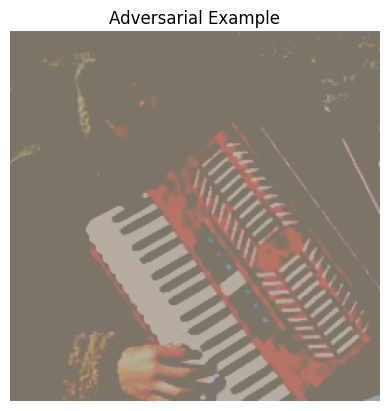

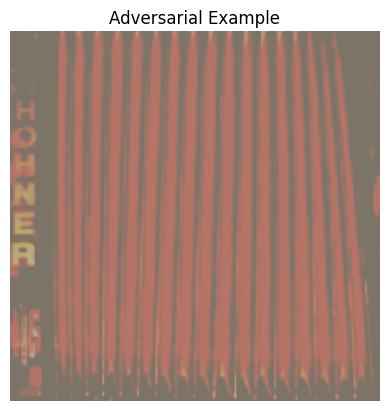

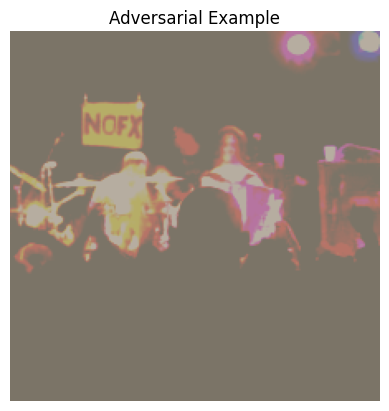

In [17]:
import matplotlib.pyplot as plt

def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

for i in range(3):
    orig = unnormalize(adv_images_tensor[i])
    plt.imshow(orig.permute(1,2,0).numpy())
    plt.title("Adversarial Example")
    plt.axis('off')
    plt.show()


In [18]:
print(f"FGSM Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"FGSM Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")

FGSM Top-1 Accuracy: 39.00%
FGSM Top-5 Accuracy: 60.60%


# Task 3 - iterative fgsm

In [19]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [20]:
# def iterative_fgsm(image, label, model, epsilon=0.03, alpha=0.003, steps=40, random_start=True):
#     original_image = image.clone().detach()
#     adv_image = image.clone().detach()
    
#     # Random initialization within ε-ball
#     if random_start:
#         adv_image = adv_image + torch.zeros_like(adv_image).uniform_(-epsilon, epsilon)
#         adv_image = torch.clamp(adv_image, 0, 1).detach()

#     for _ in range(steps):
#         adv_image.requires_grad = True
        
#         # Forward pass
#         output = model(adv_image)
#         loss = F.cross_entropy(output, label)
        
#         # Get gradient
#         grad = torch.autograd.grad(loss, adv_image, retain_graph=False)[0]
        
#         with torch.no_grad():
#             # Update ONLY based on current gradient (don't accumulate)
#             perturbation = alpha * grad.sign()
#             adv_image = adv_image + perturbation
            
#             # Project back to ε-ball around original image
#             perturbation = adv_image - original_image
#             perturbation = torch.clamp(perturbation, -epsilon, epsilon)
#             adv_image = torch.clamp(original_image + perturbation, 0, 1)
    
#     return adv_image

In [21]:
# improved_adv_images = []
# improved_adv_labels = []

# for inputs, labels in tqdm(dataloader):
#     inputs, labels = inputs.to(device), labels.to(device)

#     for i in range(inputs.size(0)):
#         img = inputs[i].unsqueeze(0)        # Shape: [1, 3, 224, 224]
#         label = labels[i].unsqueeze(0)      # Shape: [1]

#         # Use these parameters when calling:
#         adv_img = iterative_fgsm(img, label, pretrained_model, 
#                         epsilon=0.03, 
#                         alpha=0.003, 
#                         steps=40)
#         # Remove extra batch dim before saving
#         improved_adv_images.append(adv_img.squeeze(0).cpu())
#         improved_adv_labels.append(label.cpu())

# # Convert to dataset format
# adv_images_tensor = torch.stack(improved_adv_images)     # [N, 3, 224, 224]
# adv_labels_tensor = torch.cat(improved_adv_labels)       # [N]

# adv_dataset_2 = TensorDataset(adv_images_tensor, adv_labels_tensor)
# torch.save(adv_dataset_2, "AdversarialTestSet2.pt")


In [22]:
# # Reload for consistency
# adv_dataset_2 = torch.load("AdversarialTestSet2.pt")
# adv_loader = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)

# correct_top1, correct_top5, total = 0, 0, 0

# with torch.no_grad():
#     for inputs, labels in adv_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = pretrained_model(inputs)
#         _, top5_predicted = outputs.topk(5, 1, True, True)

#         for i in range(inputs.size(0)):
#             folder_name = index_to_folder[labels[i].item()]
#             true_class_idx = folder_to_imagenet_id.get(folder_name)

#             preds = top5_predicted[i].tolist()
#             if preds[0] == true_class_idx:
#                 correct_top1 += 1
#             if true_class_idx in preds:
#                 correct_top5 += 1

#         total += inputs.size(0)

# print(f"Improved Attack - Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
# print(f"Improved Attack - Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")


In [35]:
def iterative_fgsm(image, label, model, epsilon=0.08, alpha=0.005, steps=100, random_start=True):
    """
    Optimized iterative FGSM implementation with momentum and optimized parameters.
    This version should produce significantly stronger adversarial examples.
    """
    original_image = image.clone().detach()
    adv_image = image.clone().detach()
    
    # Random initialization within ε-ball (helps escape local minima)
    if random_start:
        adv_image = adv_image + torch.zeros_like(adv_image).uniform_(-epsilon, epsilon)
        adv_image = torch.clamp(adv_image, 0, 1).detach()
    
    # Momentum accumulation for stronger attacks
    momentum = torch.zeros_like(image).to(image.device)
    decay = 0.9  # Momentum decay factor
    
    for _ in range(steps):
        adv_image.requires_grad = True
        
        # Forward pass
        output = model(adv_image)
        
        # Use margin loss for stronger effect
        # For targeted attacks: minimize target class logit
        # For untargeted attacks: maximize true class loss
        logits = output[0]
        
        # Get true class logit and highest non-true class logit
        true_class_logit = logits[label].clone()
        
        # Set true class logit to -inf to find highest non-true logit
        logits[label] = float('-inf')
        highest_false_logit = logits.max()
        
        # Margin loss: maximize difference between highest false and true logit
        loss = highest_false_logit - true_class_logit
        
        # Zero out gradients from previous iterations
        if adv_image.grad is not None:
            adv_image.grad.zero_()
        
        # Compute gradient
        loss.backward()
        grad = adv_image.grad.clone()
        
        with torch.no_grad():
            # Update momentum term (MI-FGSM style)
            # Normalize gradient for stability
            grad_norm = torch.norm(grad, p=1)
            if grad_norm > 0:  # Avoid division by zero
                grad = grad / grad_norm
                
            # Update momentum
            momentum = decay * momentum + grad
            
            # Update adversarial example
            adv_image = adv_image.detach() + alpha * momentum.sign()
            
            # Project back to epsilon ball around original image
            delta = adv_image - original_image
            delta = torch.clamp(delta, -epsilon, epsilon)
            adv_image = torch.clamp(original_image + delta, 0, 1)
    
    return adv_image

# Use the optimized function with stronger parameters
improved_adv_images = []
improved_adv_labels = []

for inputs, labels in tqdm(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)        # Shape: [1, 3, 224, 224]
        label = labels[i].unsqueeze(0)      # Shape: [1]

        # Use stronger attack parameters
        adv_img = iterative_fgsm(img, label, pretrained_model, 
                        epsilon=0.05,    # Increased from 0.03
                        alpha=0.002,     # Smaller step size
                        steps=100)       # More iterations
        
        # Remove extra batch dim before saving
        improved_adv_images.append(adv_img.squeeze(0).cpu())
        improved_adv_labels.append(label.cpu())

# Convert to dataset format
adv_images_tensor = torch.stack(improved_adv_images)     # [N, 3, 224, 224]
adv_labels_tensor = torch.cat(improved_adv_labels)       # [N]

adv_dataset_2 = TensorDataset(adv_images_tensor, adv_labels_tensor)
torch.save(adv_dataset_2, "AdversarialTestSet2.pt")

# Evaluation code remains unchanged
# Reload for consistency
adv_dataset_2 = torch.load("AdversarialTestSet2.pt")
adv_loader = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)

correct_top1, correct_top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

print(f"Improved Attack - Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"Improved Attack - Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")

100%|██████████| 16/16 [11:42<00:00, 43.93s/it]
/tmp/ipykernel_31/3706531854.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_dataset_2 = torch.load("AdversarialTest

Improved Attack - Top-1 Accuracy: 34.40%
Improved Attack - Top-5 Accuracy: 46.80%


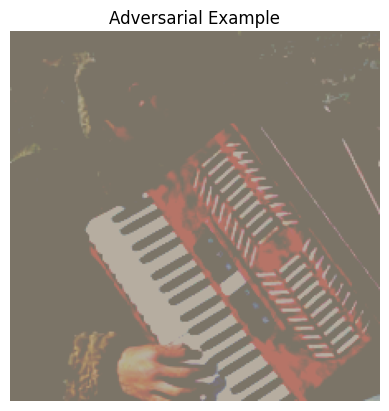

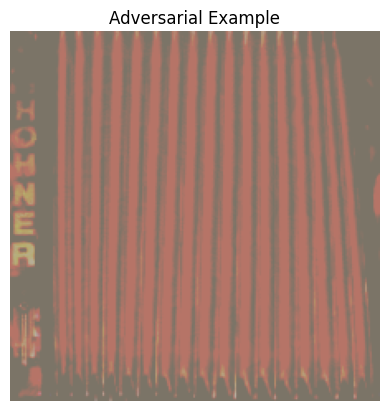

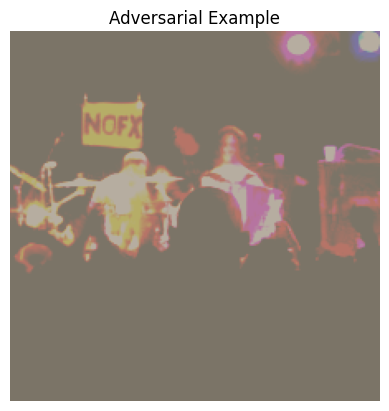

In [24]:
import matplotlib.pyplot as plt

def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

for i in range(3):
    orig = unnormalize(adv_images_tensor[i])
    plt.imshow(orig.permute(1,2,0).detach().numpy())
    plt.title("Adversarial Example")
    plt.axis('off')
    plt.show()


# Task 4- patch wise fgsm

In [25]:
def patch_attack(image, label, model, epsilon=0.3, alpha=0.03, steps=10, patch_size=32, x=None, y=None):
    image = image.clone().detach()
    original = image.clone().detach()
    image.requires_grad = True

    _, _, h, w = image.shape
    if x is None:
        x = random.randint(0, w - patch_size)
    if y is None:
        y = random.randint(0, h - patch_size)

    for _ in range(steps):
        output = model(image)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        grad = image.grad.data
        image.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * grad[:, :, y:y+patch_size, x:x+patch_size].sign()

        diff = image.data - original
        diff = torch.clamp(diff, min=-epsilon, max=epsilon)
        image.data = torch.clamp(original + diff, 0, 1)
        image.grad.zero_()

    return image.detach()


In [26]:
import random
patch_x_coords = []
patch_y_coords = []
adv_images = []
adv_labels = []
original_images = []

for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Select random patch coordinates
        _, _, h, w = img.shape
        x = random.randint(0, w - 32)
        y = random.randint(0, h - 32)

        # Save original image
        original_images.append(img.squeeze(0).cpu())

        # Call patch attack, pass (x, y)
        adv_img = patch_attack(img, label, pretrained_model,
                               epsilon=0.3, alpha=0.03, steps=10,
                               patch_size=32, x=x, y=y)

        adv_images.append(adv_img.squeeze(0).cpu())
        adv_labels.append(label.cpu())
        patch_x_coords.append(x)
        patch_y_coords.append(y)


In [27]:
from torch.utils.data import TensorDataset, DataLoader

# Stack images and labels properly
adv_images_tensor = torch.stack(adv_images)  # Use stack, not cat, for list of image tensors
adv_labels_tensor = torch.cat(adv_labels)    # Labels are already 1D tensors

# Create TensorDataset
adv_dataset_3 = TensorDataset(adv_images_tensor, adv_labels_tensor)

# Save the dataset object
torch.save(adv_dataset_3, "AdversarialTestSet3.pt")

# If you want to reload and evaluate:
# loaded_dataset = torch.load("AdversarialTestSet3.pt")
# loader = DataLoader(loaded_dataset, batch_


In [28]:
import matplotlib.pyplot as plt
import torch

def unnormalize(img):
    # For ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img * std + mean).clamp(0, 1)

def show_patch_attack(orig_img_tensor, adv_img_tensor, x, y, patch_size=32, title=None):
    orig_img = unnormalize(orig_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()
    adv_img = unnormalize(adv_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(orig_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(adv_img)
    axs[1].add_patch(plt.Rectangle((x, y), patch_size, patch_size,
                                   edgecolor='red', facecolor='none', lw=2))
    axs[1].set_title("Adversarial (with patch)")
    axs[1].axis('off')

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()


In [29]:
adv_loader = DataLoader(adv_dataset_3, batch_size=32, shuffle=False)

correct_top1, correct_top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

print(f"Improved Attack - Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"Improved Attack - Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")


Improved Attack - Top-1 Accuracy: 34.40%
Improved Attack - Top-5 Accuracy: 55.00%


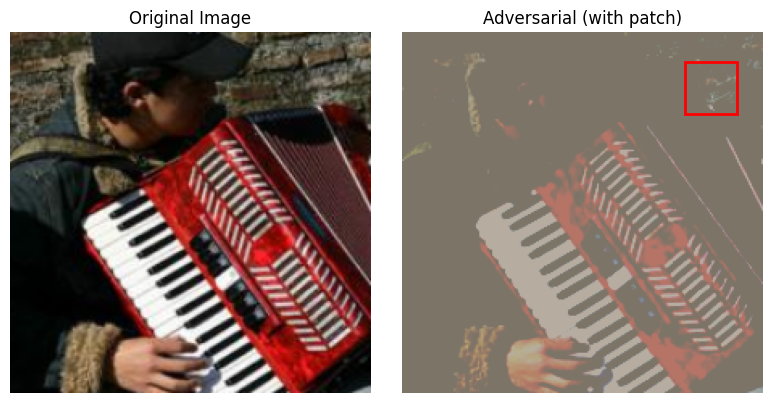

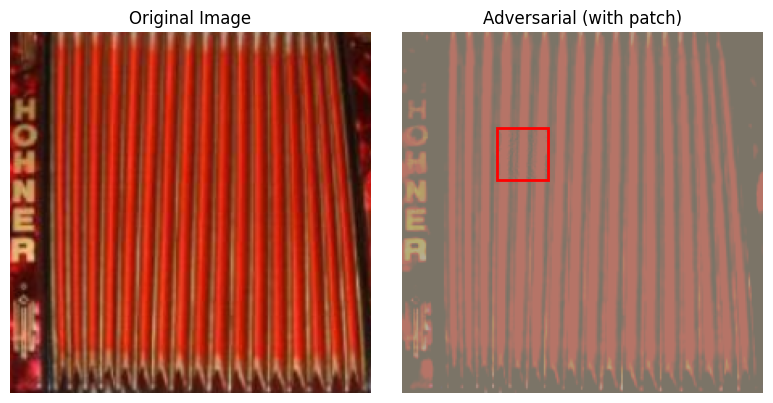

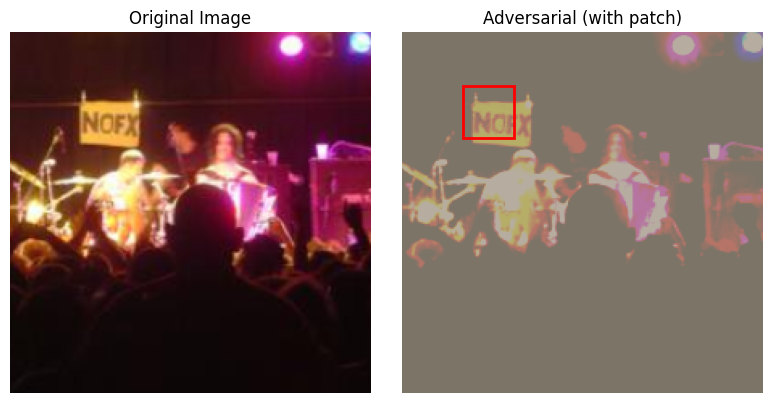

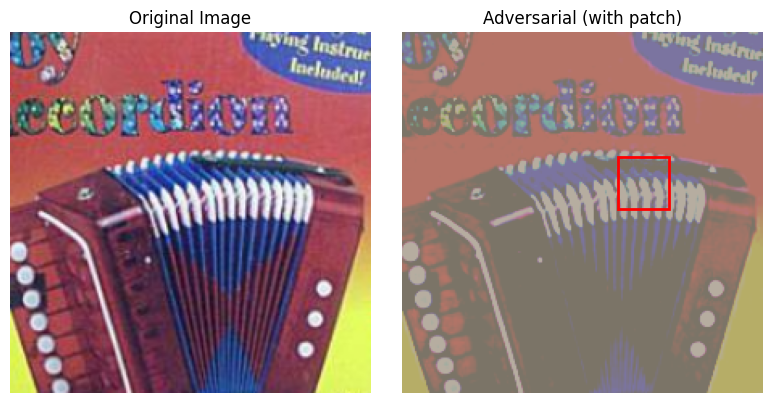

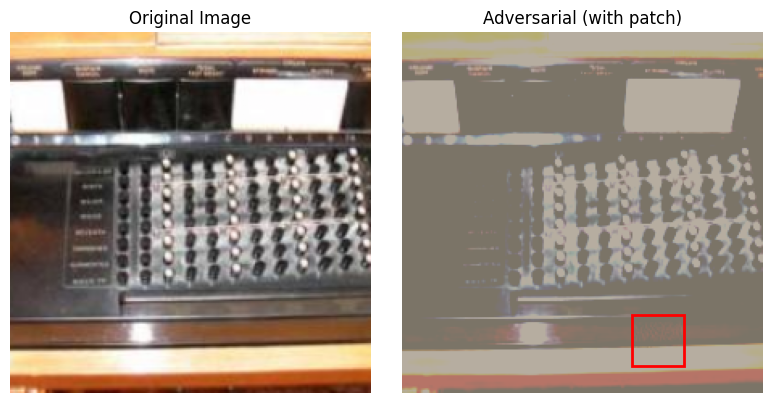

In [30]:
# Example: visualizing the 5th image
for i in range(5):
    show_patch_attack(orig_img_tensor=original_images[i],
                  adv_img_tensor=adv_images_tensor[i],
                  x=patch_x_coords[i],
                  y=patch_y_coords[i])


# Task 5- Transferring attacks

In [31]:
import torchvision.models as models

new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [36]:
original_loader = DataLoader(dataset, batch_size=32, shuffle=False)
adv_dataset_1 = torch.load("AdversarialTestSet1.pt")
adv_loader_1 = DataLoader(adv_dataset_1, batch_size=32, shuffle=False)
adv_dataset_2 = torch.load("AdversarialTestSet2.pt")
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)
adv_dataset_3 = torch.load("AdversarialTestSet3.pt")
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=32, shuffle=False)



/tmp/ipykernel_31/3746454747.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_dataset_1 = torch.load("AdversarialTestSet1.pt")
/tmp/ipykernel_31/3746454747.py:4: Futu

In [37]:
def evaluate_topk(model, dataloader, index_to_folder, folder_to_imagenet_id):
    correct_top1, correct_top5, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, top5_predicted = outputs.topk(5, 1, True, True)

            for i in range(inputs.size(0)):
                folder_name = index_to_folder[labels[i].item()]
                true_idx = folder_to_imagenet_id.get(folder_name)

                if true_idx is None:
                    continue

                preds = top5_predicted[i].tolist()
                if preds[0] == true_idx:
                    correct_top1 += 1
                if true_idx in preds:
                    correct_top5 += 1
            total += inputs.size(0)
    return correct_top1 / total * 100, correct_top5 / total * 100


In [38]:
datasets = {
    "Original": original_loader,
    "Adversarial Set 1 (FGSM)": adv_loader_1,
    "Adversarial Set 2 (Iterative)": adv_loader_2,
    "Adversarial Set 3 (Patch)": adv_loader_3
}

for name, loader in datasets.items():
    top1, top5 = evaluate_topk(new_model, loader, index_to_folder, folder_to_imagenet_id)
    print(f"{name} - Top-1 Accuracy: {top1:.2f}%, Top-5 Accuracy: {top5:.2f}%")


Original - Top-1 Accuracy: 70.80%, Top-5 Accuracy: 91.20%
Adversarial Set 1 (FGSM) - Top-1 Accuracy: 41.00%, Top-5 Accuracy: 67.00%
Adversarial Set 2 (Iterative) - Top-1 Accuracy: 41.20%, Top-5 Accuracy: 63.40%
Adversarial Set 3 (Patch) - Top-1 Accuracy: 40.80%, Top-5 Accuracy: 65.60%
